In [1]:
!nvidia-smi

Mon Aug 12 19:47:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX 6000 Ada Gene...    Off | 00000000:1A:00.0 Off |                  Off |
| 30%   53C    P8              30W / 300W |     14MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!nvidia-smi | grep '/vol/bitbucket/ms922/myenv/bin/python' | awk '{ print $5 }' | xargs -n1 kill -9


Usage:
 kill [options] <pid> [...]

Options:
 <pid> [...]            send signal to every <pid> listed
 -<signal>, -s, --signal <signal>
                        specify the <signal> to be sent
 -q, --queue <value>    integer value to be sent with the signal
 -l, --list=[<signal>]  list all signal names, or convert one to a name
 -L, --table            list all signal names in a nice table

 -h, --help     display this help, and exit
 -V, --version  output version information, and exit

For more details, see kill(1).


In [1]:
from plane_detection.SononetInference import *
from dm_ultrasound_util import *

/vol/bitbucket/ms922/glad/dm_ultrasound_util.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/vol/bitbucket/ms922/myenv/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [2]:
def extract_planes_from_video(args, plane_detector):
    print("Extracting planes...")

    class_list = [
        '3VT', '4CH', 'ABDOMINAL', 'BACKGROUND', 
        'BRAIN-CB', 'BRAIN-TV', 'FEMUR', 'KIDNEYS', 
        'LIPS', 'LVOT', 'PROFILE', 'RVOT', 'SPINE-CORONAL', 
        'SPINE-SAGITTAL'
    ]

    # all_frame_list = [[] for _ in range(len(class_list))]
    all_frame_list = []
    detected_class_list = []

    video = cv2.VideoCapture(args.video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    # Initialize tqdm progress bar
    with tqdm(total=total_frames, desc="Processing Video Frames") as pbar:
        i = 0
        success, frame = video.read()
        
        while success:
            if i % args.process_every_x_frame == 0:
                gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                confidence_score, pred_plane, saliency_map = plane_detector.detect_scan_planes(gray_frame)
                
                all_frame_list.append(gray_frame)
                detected_class_list.append(class_list.index(pred_plane))

            success, frame = video.read()
            i += 1

            # Update progress bar
            pbar.update(1)

    return all_frame_list, detected_class_list

In [3]:
parser = add_shared_args()

parser.add_argument('--lr_teacher', type=float, default=0.01, help='learning rate for updating network parameters')
parser.add_argument('--batch_syn', type=int, default=None, help='batch size for syn data')
parser.add_argument('--buffer_path', type=str, default='./buffers', help='buffer path')
parser.add_argument('--load_all', action='store_true')
parser.add_argument('--max_start_epoch', type=int, default=5)
parser.add_argument('--max_files', type=int, default=None)
parser.add_argument('--max_experts', type=int, default=None)
parser.add_argument('--expert_epochs', type=int, default=3, help='how many expert epochs the target params are')
parser.add_argument('--syn_steps', type=int, default=20, help='how many steps to take on synthetic data')

parser.add_argument('--lr_img', type=float, default=1, help='learning rate for pixels or f_latents')
parser.add_argument('--lr_w', type=float, default=0.001, help='learning rate for updating synthetic latent w')
parser.add_argument('--lr_lr', type=float, default=1e-06, help='learning rate learning rate')
parser.add_argument('--lr_g', type=float, default=0.1, help='learning rate for gan weights')

parser.add_argument('--lr_net', type=float, default=0.01, help='learning rate for updating network parameters')
parser.add_argument('--dis_metric', type=str, default='ours', help='distance metric')
parser_bool(parser, 'net_decay', False)

parser.add_argument('--nz', type=int, default=100, help='DCGAN latent dimension size')


parser.add_argument('--net_num', type=int, default=10, help='Number of networks to use')
parser.add_argument('--fetch_net_num', type=int, default=2, help='Number of networks to fetch')
parser.add_argument('--train_net_num', type=int, default=2, help='Number of networks to train')
parser.add_argument('--net_generate_interval', type=int, default=30, help='Interval for network generation')
parser.add_argument('--net_begin', type=int, default=0, help='Starting value for network ID range')
parser.add_argument('--net_end', type=int, default=100000, help='Ending value for network ID range')
parser.add_argument('--aug_num', type=int, default=1, help='Number of augmentations')
parser.add_argument('--outer_loop', type=int, default=1, help='Number of outer loop iterations')
parser.add_argument('--inner_loop', type=int, default=1, help='Number of inner loop iterations')
parser.add_argument('--model_train_steps', type=int, default=10, help='Number of training steps for the model')
parser.add_argument('--trained_bs', type=int, default=256, help='Batch size for training')

parser.add_argument('--mismatch_type', type=str, default='l1', help='Type of mismatch to use')
parser.add_argument('--ij_selection', type=str, default='random', help='Selection method for i and j')

parser.add_argument('--ce_weight', type=float, default=0.1, help='Weight for cross-entropy loss')
parser.add_argument('--sample_ratio', type=float, default=0.01, help='Subset selection ratio')


parser.add_argument('--init', type=str, default='random', choices=['random', 'real'],
                        help='whether to initialize the latent using the random initialization or random real image selection.')
parser.add_argument('--gan_type', type=str, default='dcgan', choices=['dcgan', 'stylegan2'],
                        help='GAN model to use.')
parser.add_argument('--method', type=str, default='dm', choices=['dm', 'idm', "idm_ce"],
                                help='Dataset condensation method')

parser_bool(parser, 'syn_ce', False)
parser_bool(parser, 'add_variance', False)
parser_bool(parser, 'use_gan', True)


args = parser.parse_args([])

In [4]:
args.use_sample_ratio = bool(args.sample_ratio is not None or args.sample_ratio > 0)
args.Iteration = 2000 if args.method == "dm" else 1000

args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.dsa_param = ParamDiffAug()
args.dsa = False if args.dsa_strategy in ['none', 'None'] else True

In [5]:
args.process_every_x_frame = 1
args.video_path = "/vol/bitbucket/ms922/bkainz_data/videos/iFIND01622_20Jul2015_1.MP4"


In [25]:
sononet = SononetInference()
all_frame_list, detected_class_list = extract_planes_from_video(args, sononet)

/vol/bitbucket/ms922/myenv/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(
2024-08-12 19:25:44.513 | INFO     | plane_detection.SononetInference:__init__:39 - Running on device: CPU


Extracting planes...


Processing Video Frames:   0%|          | 0/27045 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [6]:
test_all_frame_list_path = "./video_frame/"

if not os.path.exists(test_all_frame_list_path):
    os.makedirs(test_all_frame_list_path)

test_all_frame_list_file_path = os.path.join(test_all_frame_list_path, "test1.pkl")

In [ ]:
with open(test_all_frame_list_file_path, 'wb') as file:
    pickle.dump(all_frame_list, file)
    print(f"Save at {test_all_frame_list_file_path}")

In [7]:
if os.path.exists(test_all_frame_list_file_path):
    with open(test_all_frame_list_file_path, 'rb') as file:
        all_frame_list = pickle.load(file)

In [8]:
all_frame_list_new, detected_class_list = all_frame_list

In [9]:
class VideoFrameDataset(Dataset):
    def __init__(self, video_frame_list, class_list, transform=None):

        self.images = video_frame_list
        self.labels = class_list
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [10]:
channel = 1
im_size = (args.res, args.res)
mean = [0.5]
std = [0.5]
num_classes = 14

transform = transforms.Compose([transforms.ToTensor(),
                        transforms.Normalize(mean=mean, std=std),
                        transforms.Resize(args.res),
                        transforms.CenterCrop(args.res)])

class_names = None
class_map = {x:x for x in range(num_classes)}
class_map_inv = {x: x for x in range(num_classes)}

dst_train = VideoFrameDataset(all_frame_list_new, detected_class_list, transform)
class_names = None
class_map = {x:x for x in range(num_classes)}
class_map_inv = {x: x for x in range(num_classes)}

images_all, labels_all, indices_class = build_dataset(dst_train, class_map, num_classes)


BUILDING DATASET


100%|██████████| 27045/27045 [00:20<00:00, 1294.59it/s]
27045it [00:00, 4272985.71it/s]


In [11]:
class_counts = np.bincount(labels_all, minlength=num_classes)
class_counts

array([  120,   816,   413, 18275,   746,  1055,  1044,   103,  1794,
           0,    26,   645,     8,  2000])

In [12]:
if args.use_sample_ratio:
    n_sample_list = get_sample_syn_label(labels_all, args.sample_ratio, num_classes=num_classes, min_syn=10, max_syn=200)
    print(sum(n_sample_list))
    print(n_sample_list)

332
[ 10  10  10 183  10  11  10  10  18  10  10  10  10  20]


In [13]:
img_class_cnt = [0]*num_classes
for c in labels_all:
    img_class_cnt[c] += 1
img_class_cnt

[120, 816, 413, 18275, 746, 1055, 1044, 103, 1794, 0, 26, 645, 8, 2000]

In [14]:
n_sample_list

array([ 10,  10,  10, 183,  10,  11,  10,  10,  18,  10,  10,  10,  10,
        20])

In [15]:
ignore_class = [c for c in range(num_classes) if n_sample_list[c] >= img_class_cnt[c]]
ignore_class

[9, 12]

/vol/bitbucket/ms922/glad/dm_ultrasound_util.py:661: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(model_path))


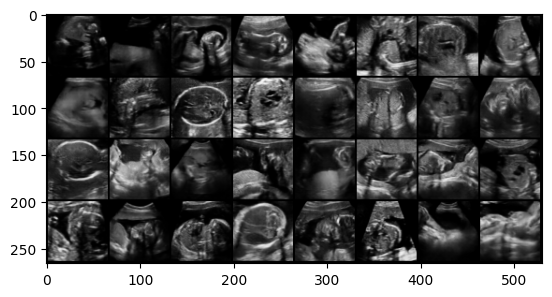

In [16]:
if args.use_gan:
    mean_tensor = torch.Tensor([0.5])
    std_tensor = torch.Tensor([0.5])
else:
    mean_tensor = torch.Tensor(mean)
    std_tensor = torch.Tensor(std)
unnormalize = transforms.Normalize((-mean_tensor / std_tensor).tolist(), (1.0 / std_tensor).tolist())

gan_model_path = "./gan/models/net_G_relu_64_video_net_new_epoch_49.pth"
if args.use_gan:
    generator = get_dcgan(args, gan_model_path, ngf=64, channel=channel, display_img=True, unnormalize=unnormalize)
else:
    generator = None

In [17]:
args.method = "dm"

In [18]:
if args.method == "dm":
    latents_tmp = run_dm(
        args, 
        indices_class, 
        images_all, 
        channel, 
        num_classes, 
        im_size=im_size, 
        generator=generator, 
        n_sample_list=n_sample_list, 
        is_save_img=True, 
        is_save_latent=True,
        unnormalize=unnormalize,
        ignore_class = ignore_class
    )
elif args.method in ["idm", "idm_ce"]:
    latents_tmp = run_idm(
        args, 
        indices_class, 
        images_all, 
        labels_all,
        channel, 
        num_classes, 
        im_size=im_size, 
        generator=generator, 
        n_sample_list=n_sample_list, 
        is_save_img=True, 
        is_save_latent=True,
        unnormalize=unnormalize,
        ignore_class = ignore_class
    )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jack47744. Use `wandb login --relogin` to force relogin


Sample with ratio of 0.01
Hyper-parameters: 
 {'dataset': 'ultrasound', 'model': 'ConvNet', 'ipc': 50, 'eval_mode': 'M', 'num_eval': 5, 'eval_it': 100, 'save_it': None, 'epoch_eval_train': 100, 'Iteration': 2000, 'mom_img': 0.5, 'batch_real': 256, 'batch_train': 256, 'batch_test': 128, 'pix_init': 'noise', 'dsa': True, 'dsa_strategy': 'color_crop_cutout_flip_scale_rotate', 'data_path': 'data', 'save_path': 'result', 'space': 'p', 'res': 64, 'layer': 12, 'avg_w': False, 'eval_all': False, 'min_it': False, 'no_aug': False, 'force_save': False, 'sg_batch': 10, 'rand_f': False, 'logdir': './logged_files', 'wait_eval': False, 'idc_factor': 1, 'rand_gan_un': False, 'rand_gan_con': False, 'learn_g': False, 'width': 128, 'depth': 4, 'special_gan': None, 'lr_teacher': 0.01, 'batch_syn': None, 'buffer_path': './buffers', 'load_all': False, 'max_start_epoch': 5, 'max_files': None, 'max_experts': None, 'expert_epochs': 3, 'syn_steps': 20, 'lr_img': 1, 'lr_w': 0.001, 'lr_lr': 1e-06, 'lr_g': 0.1, 'l

Training Progress:   0%|          | 0/2001 [00:00<?, ?it/s]

/vol/bitbucket/ms922/myenv/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[2024-08-12 19:54:59] iter = 0000, loss = 131.8088
[2024-08-12 19:55:09] iter = 0050, loss = 90.8695
[2024-08-12 19:55:19] iter = 0100, loss = 79.8738
[2024-08-12 19:55:29] iter = 0150, loss = 66.1601
[2024-08-12 19:55:38] iter = 0200, loss = 60.1410
Save at ./dm_latents/ultrasound/0__01_ori_0200.pt
[2024-08-12 19:55:48] iter = 0250, loss = 54.8776
[2024-08-12 19:55:58] iter = 0300, loss = 54.2174
[2024-08-12 19:56:08] iter = 0350, loss = 54.4420
[2024-08-12 19:56:18] iter = 0400, loss = 45.7500
Save at ./dm_latents/ultrasound/0__01_ori_0400.pt
[2024-08-12 19:56:28] iter = 0450, loss = 40.6011
[2024-08-12 19:56:38] iter = 0500, loss = 43.1530
[2024-08-12 19:56:48] iter = 0550, loss = 42.8482
[2024-08-12 19:56:59] iter = 0600, loss = 39.0936
Save at ./dm_latents/ultrasound/0__01_ori_0600.pt
[2024-08-12 19:57:09] iter = 0650, loss = 41.4453
[2024-08-12 19:57:19] iter = 0700, loss = 39.1838
[2024-08-12 19:57:29] iter = 0750, loss = 36.4402
[2024-08-12 19:57:39] iter = 0800, loss = 34.3992

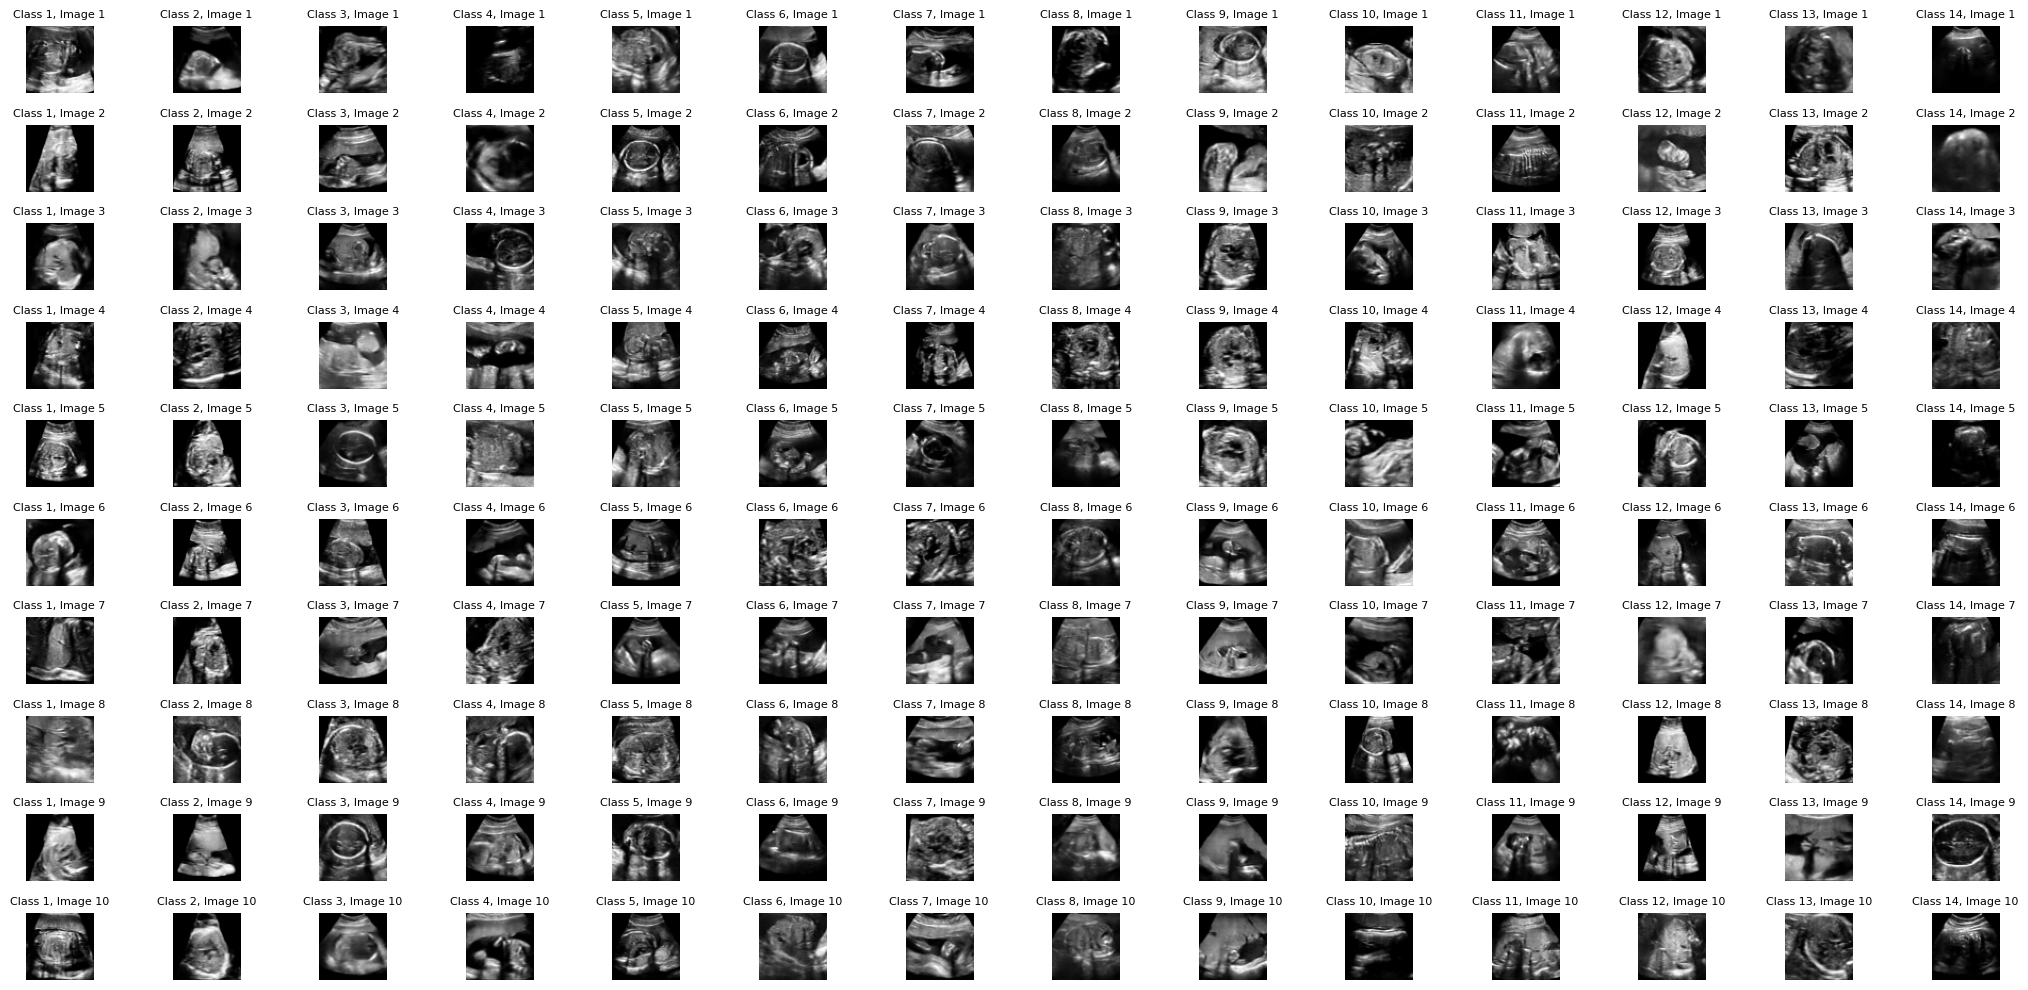

In [19]:
if args.use_sample_ratio:
    sampled_tensors = sample_tensors(latents_tmp, n_sample_list, min(n_sample_list))
    display_latent(sampled_tensors, num_classes, min(n_sample_list), args, True, channel=channel, im_size=im_size, unnormalize=unnormalize)
else:
    display_latent(latents_tmp, num_classes, args.ipc, args, True, channel=channel, im_size=im_size, unnormalize=unnormalize)

In [20]:
if args.use_sample_ratio:
    tensor_split = split_tensor_to_list(latents_tmp, n_sample_list)

In [21]:
embed_list = get_embed_list(args, channel, num_classes, im_size, num_net=10)

if args.use_sample_ratio:
    mse_latent_dict, latent_embed_mean_list, img_latent_mean_all_list = get_most_similar_img(
        tensor_split, args, indices_class, images_all, is_stack=False, embed_list=embed_list, ret_img_latent=True
    )
else:
    mse_latent_dict, latent_embed_mean_list = get_most_similar_img(latents_tmp, args, embed_list=embed_list)

  0%|          | 0/120 [00:00<?, ?it/s]

Processing Latents:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/816 [00:00<?, ?it/s]

Processing Latents:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/413 [00:00<?, ?it/s]

Processing Latents:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/18275 [00:00<?, ?it/s]

Processing Latents:   0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/746 [00:00<?, ?it/s]

Processing Latents:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1055 [00:00<?, ?it/s]

Processing Latents:   0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

Processing Latents:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

Processing Latents:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1794 [00:00<?, ?it/s]

Processing Latents:   0%|          | 0/18 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Processing Latents:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Processing Latents:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/645 [00:00<?, ?it/s]

Processing Latents:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Processing Latents:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Processing Latents:   0%|          | 0/20 [00:00<?, ?it/s]

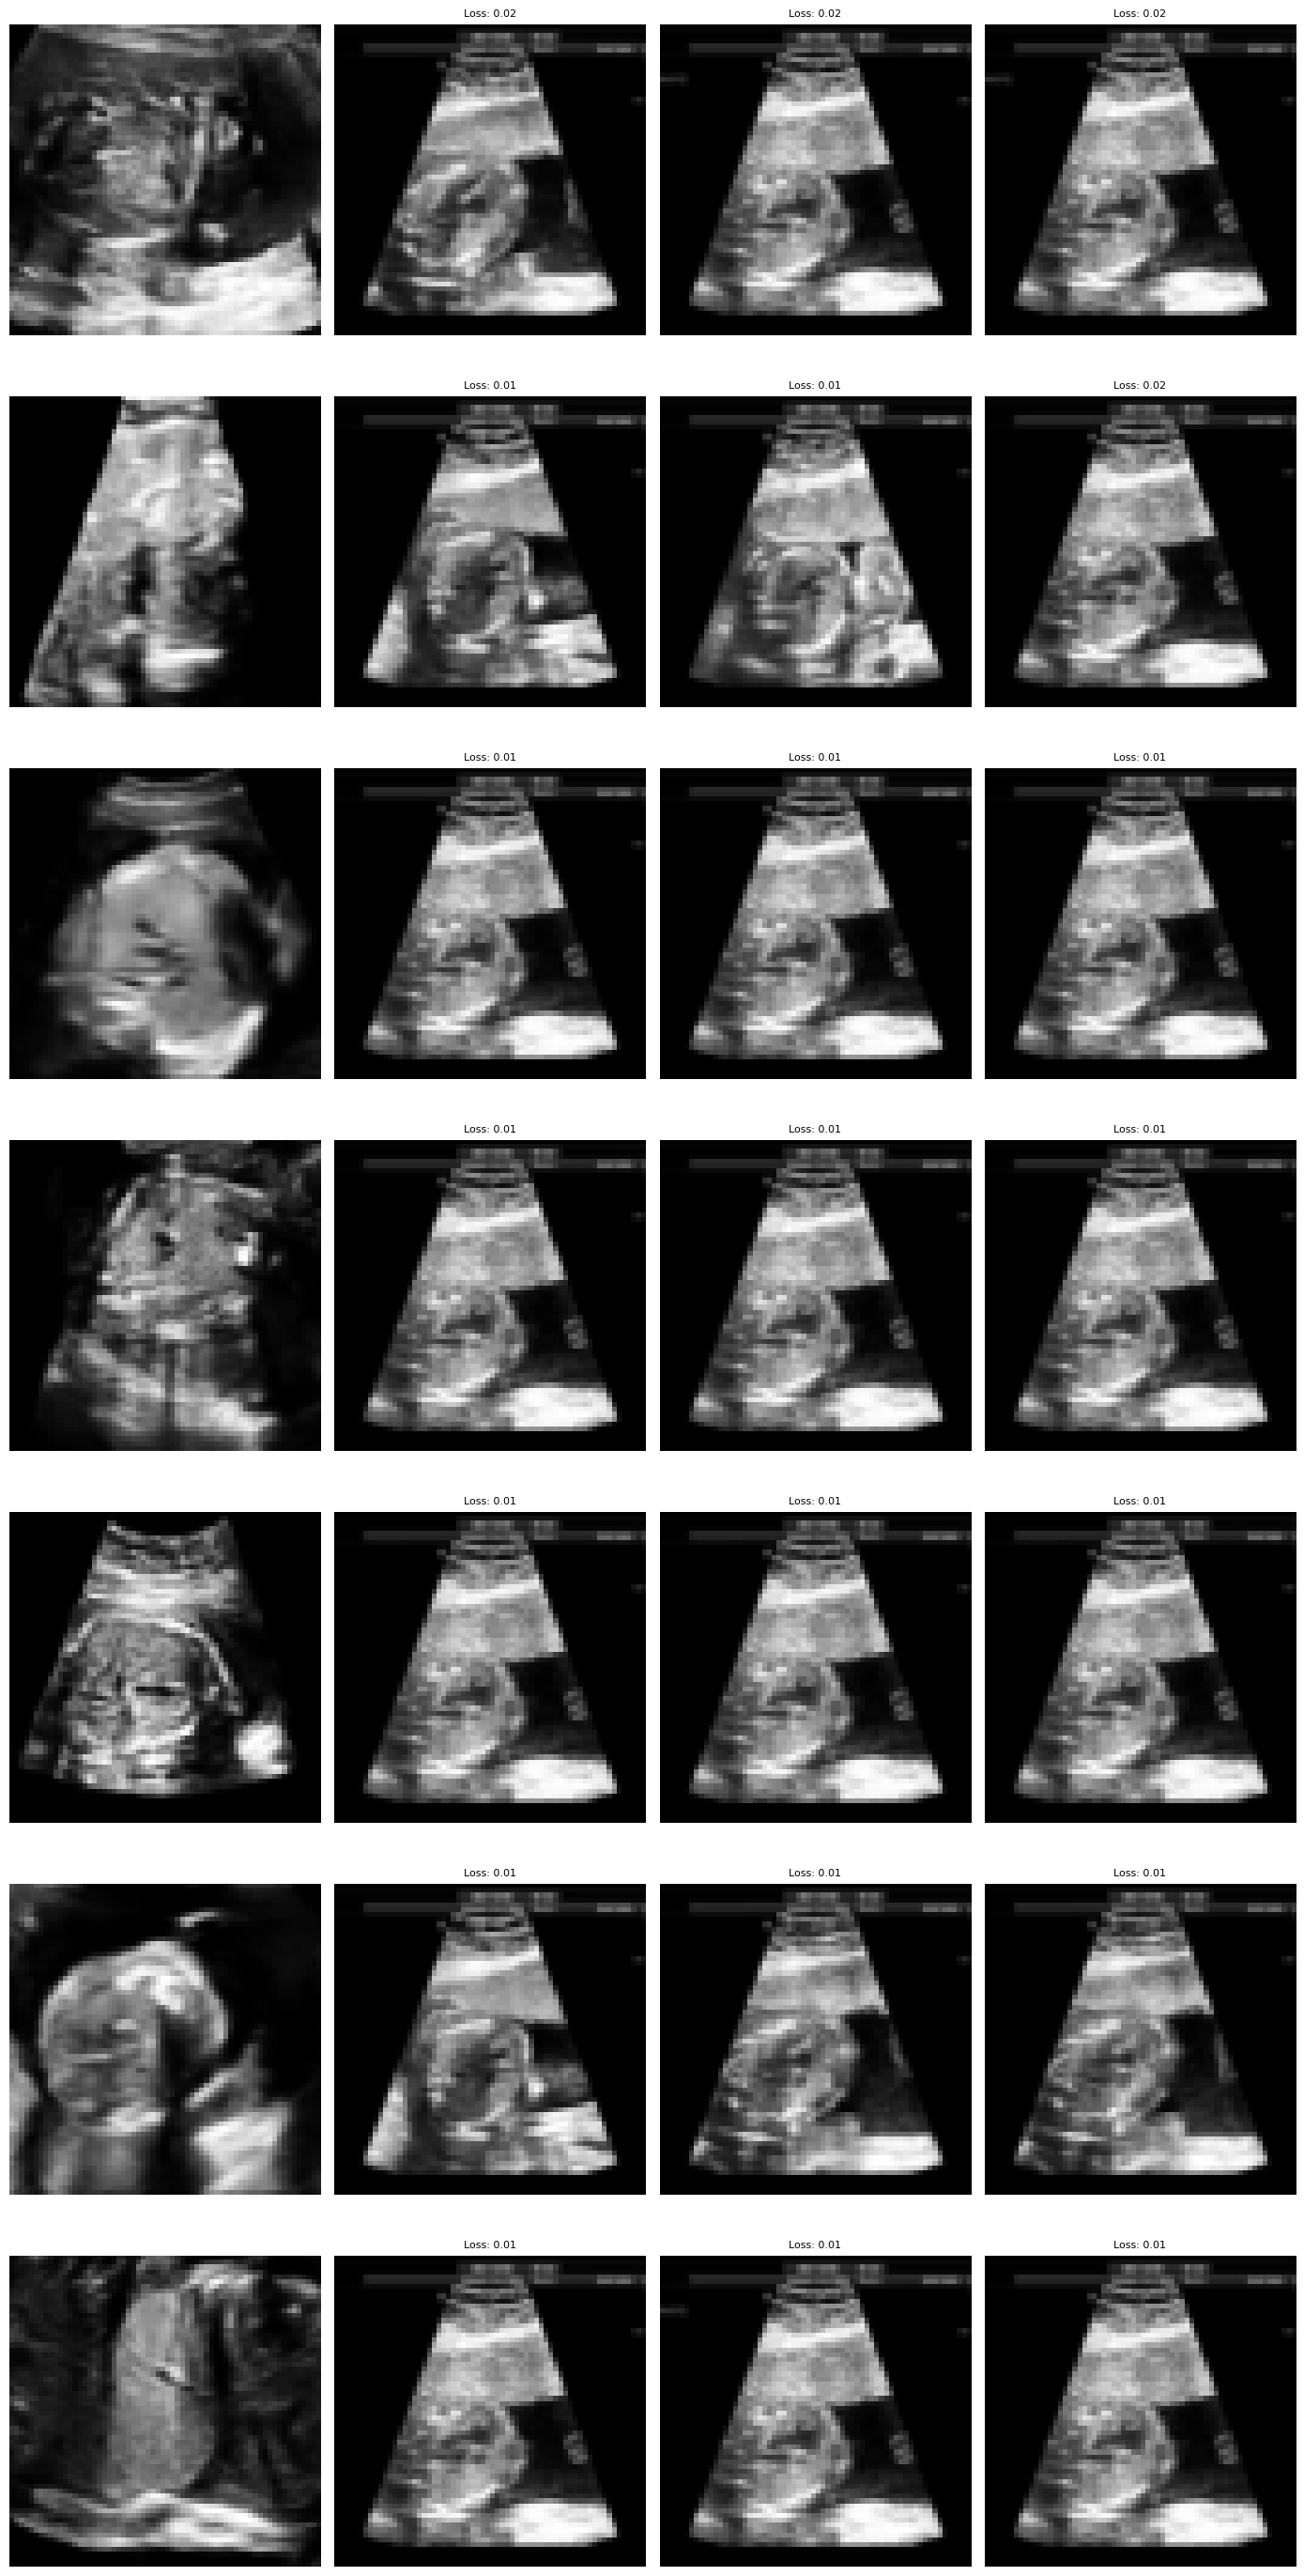

In [24]:
top_k = 3
num_img = 7

for c in range(num_classes):
    all_img_top_k_list = []
    similarity_loss_list = []
    for latent_idx in range(num_img):

        k = (c, latent_idx)
        mse_val_list = sorted(mse_latent_dict[k])[:top_k]
        top_img_idx = [e[1] for e in mse_val_list]
        similarity_loss = [e[0] for e in mse_val_list]
        top_imgs = images_all[top_img_idx].detach().cpu()
        if args.use_sample_ratio:
            latent = torch.unsqueeze(tensor_split[c][latent_idx], 0).detach().cpu()
        else:
            latent = torch.unsqueeze(latents_tmp[(c, latent_idx)], 0).detach().cpu()
        if len(latent.shape) == 3:
            latent = torch.unsqueeze(latent, 0)
        # print(latent.shape, top_imgs.shape)
        all_img_top_k = torch.cat((latent, top_imgs))
        all_img_top_k_list.append(all_img_top_k)
        similarity_loss_list.append(similarity_loss)
        

    plot_images_with_similarity(args, all_img_top_k_list, similarity_loss_list, num_img, num_classes=num_classes, unnormalize=unnormalize)
    break

In [46]:
torch.random.manual_seed(0)
np.random.seed(0)
random.seed(0)

top_image_list, top_label_list, top_image_indices = get_top_img(images_all, mse_latent_dict, ignore_class=ignore_class)
top_image_list = torch.cat(top_image_list)
top_label_list = torch.tensor(top_label_list)

for c in ignore_class:
    top_image_indices += indices_class[c]
    top_label_list = torch.cat((top_label_list, torch.tensor([c]*len(indices_class[c]))))

assert top_label_list.shape[0] == len(top_image_indices)



 ----- top k: 1 ----- 


  0%|          | 0/322 [00:00<?, ?it/s]

torch.Size([320]) 320


In [59]:
def save_video_frame(path, all_frame_list, top_label_list, top_image_indices, num_classes):
    all_frames = np.array(all_frame_list)[top_image_indices]

    for c in range(num_classes):
        class_path = os.path.join(path, f"{c:02}")
        if not os.path.exists(class_path):
            os.makedirs(class_path)

    assert all_frames.shape[0] == top_label_list.shape[0] == len(top_image_indices)
    for frame, c, idx in tqdm(zip(all_frames, top_label_list, top_image_indices), total=len(top_image_indices)):
        class_path = os.path.join(path, f"{int(c):02}")
        image = Image.fromarray(frame)
        image.save(os.path.join(class_path, f"{idx}.png"))    

In [60]:
output_path = "./video/output_subset_test1"
save_video_frame(output_path, all_frame_list_new, top_label_list, top_image_indices, num_classes)

  0%|          | 0/320 [00:00<?, ?it/s]

In [64]:
!ls ./video/output_subset_test1/00

11967.png  12045.png  12079.png  12114.png  12128.png  12450.png  12936.png
